# Histopathologic Cancer Detection 

Lets just start with some imports straight away

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns 
from sklearn.utils import shuffle
import logging
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adadelta
from pyspark.sql import SparkSession

logger = logging.getLogger()

## Purpose and goal definition

Our purpose is to be able to identify metastatic cancer in small image patches taken from larger digital pathology scans, specifically of lymph node sections. Both of us were highly interested in medical, preferebly brain problem, but after not finding a good enough dataset on kaggle for brain pathologies we decided to go with the Histopathologic Cancer Detection dataset which spiked our interest. 

We believe solving these groups of problems is highly important. Being able to detect cancer using an algorithem can potentially shorten detection and diagnosis times, reduce human error and subsequentially save patient lives and reduce further complications.

### So why is solving the Histopathologic Cancer Detection dataset challenge so important?
The **lymph system** is a part of our immune system. It includes a network of lymph vessels and nodes. Lymph vessels are a lot like the veins that collect and carry blood through the body. But instead of carrying blood, these vessels carry the clear watery fluid called lymph. Lymph fluid also contains white blood cells, which help fight infections.

Cancer can appear in the lymph nodes in 2 ways: 
* start there (lymphoma)
* spread there from somewhere else.

In the case of this project it doesn't matter to us if it started there or spread there, the question is, is it there or not. 

Generally speaking, cancer in lymph nodes is hard to find. Normal lymph nodes are tiny and can be hard to find as is, but when there’s any kind of infection, inflammation, or cancer, the nodes can get larger. Those near the body’s surface often get big enough to feel with your fingers, and some can even be seen. But if there are only a few cancer cells in a lymph node, it may look and feel normal. Lymph nodes deep in the body cannot be felt or seen. **Essentially the only way to know whether there is cancer in a lymph node is to do a biopsy**. 

**Histopathology** is the diagnosis and study of diseases of the tissues in order to study the manifestation of different deseases, including cancer. It involves examining tissues and cells under a microscope, **a biopsy**. Histopathologists are doctors who are responsible for that study and the diagnoses that follows, they help clinicians manage a patient's care.

As we can assume, manual detection of a cancer cell is a tiresome task and involves human error. Most parts of the cell are frequently part of irregular random and arbitrary visual angles. As we already mentioned, the only way to detect cancer in a lymph node is using a biopsy. Machine learning algorithems can be applied to obtain better results as compared with manual pathological detection systems, this means that solving this challenge can be cruicial for lymph node cancer patients.  

**The goal** is to identify whether a tumor is benign or of a malignant in nature, malignant tumors are cancerous, which means they should be treated as soon as possible to reduce and prevent further complications. In other words we are dealing with a **binary classification problem**. 

### Solution evaluation

As defined by the Kaggle competition, out evaluation metric will be the area under the ROC curve between the predicted probability and the observed target, AUC. 
* **ROC** curve is a plot of True positive rate against False positive rate at various thresholds
* **AUC** is the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one

This is highly important because we are dealing with cancer tissue where a false negative can have disastrous implications. We'll be "more okay" with classifiying false positives than false negatives. In this project we'll strive to get an AUC as close to 1 as possible.

## Data collection

Data was collected directly from [Kaggle](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data). It's a slightly modified version of the PCam dataset that can be found right [here](https://github.com/basveeling/pcam). The difference between the Kaggle version and the PCam version is that the PCam version contains duplications due to it's probabalistic sampling. 

Defining the directories where our data sits, these are constants anyway so we're going to use these variables inn the future segments of our code.

In [2]:
X_data_directory = "../../data/histopathologic-cancer-detection/train/"
y_data_directory = "../../data/histopathologic-cancer-detection/train_labels.csv"

data_to_predict_directory = "../../data/histopathologic-cancer-detection/test"

Let's just check that everything is defined as needed

In [3]:
y_data_directory

'../../data/histopathologic-cancer-detection/train_labels.csv'

Lets load the labels from the CSV file

In [4]:
y_df = pd.read_csv(y_data_directory)

Looking at the dataframe we can indeed see it consists of the id, which is also present in the file name of the image and the label itself, 0 for non cancerous and 1 for cancerous.

We can indeed see that the number of labels matches the number of images loaded from the directory.

In [6]:
y_df.count

<bound method DataFrame.count of                                               id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...                                          ...    ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220025 rows x 2 columns]>

### Preprocess labels so we'd be able to use them for loading and visualizing images 

In [7]:
y_trs_df = y_df.copy()

In [8]:
y_trs_df['is_cancer'] = y_trs_df['label'].astype(bool)

We can see that we now have a 'is_cancer' column, which is that trannslated label from 0 and 1 to boolean value, this will make it easier to work with and also easier to understand.

In [9]:
y_trs_df.head()

,id,label,is_cancer
0,f38a6374c348f90b587e046aac6079959adf3835,0,False
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,True
2,755db6279dae599ebb4d39a9123cce439965282d,0,False
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,False
4,068aba587a4950175d04c680d38943fd488d6a9d,0,False


We're going to concat the file name and the directory, to have for every image it's path for future user. We're then loading the images into the same dataframe, this is all done for exploration purposes.

In [10]:
y_trs_df['file_name'] = X_data_directory + y_trs_df['id'] + ".tif"

The following dataframe is going to containt the entire dataset

In [11]:
data_pd = pd.DataFrame(y_trs_df[['id','file_name','is_cancer']])

Read all the images into the following dataframe using the cv2 imread method

In [15]:
data_pd['image'] = y_trs_df['file_name'].apply(cv.imread)

Lets take a look at how our data looks like

In [279]:
data_pd.head()

,id,file_name,is_cancer,image
0,f38a6374c348f90b587e046aac6079959adf3835,../../data/histopathologic-cancer-detection/tr...,False,"[[[244, 246, 246], [245, 247, 247], [246, 248,..."
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,../../data/histopathologic-cancer-detection/tr...,True,"[[[246, 247, 251], [245, 248, 253], [235, 238,..."
2,755db6279dae599ebb4d39a9123cce439965282d,../../data/histopathologic-cancer-detection/tr...,False,"[[[255, 236, 255], [129, 88, 126], [126, 85, 1..."
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,../../data/histopathologic-cancer-detection/tr...,False,"[[[169, 75, 134], [188, 102, 164], [205, 128, ..."
4,068aba587a4950175d04c680d38943fd488d6a9d,../../data/histopathologic-cancer-detection/tr...,False,"[[[47, 23, 93], [120, 88, 147], [62, 19, 64], ..."


Copy to a new dataframe

In [17]:
full_data_pd = data_pd.copy()

For exploration purposes we want to create a single dataframe with the image data and the label together.

## Data visualization

As written in the description of the github repository a positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable the design of fully-convolutional models that do not use any zero-padding, to ensure consistent behavior when applied to a whole-slide image. This essentially means that we can maybe crop the images and see how this influences accuracy. For now we'll keep the image as is.

In the original dataset the labels were balances between True and False and also contained information regarding the cancer in general (ie Is it cancerour? Is only the center canceros?). Kaggle removed that extra bit of information and in addition removed duplicates from the dataset.


In [282]:
full_data_pd.count()

id           220025
file_name    220025
is_cancer    220025
image        220025
dtype: int64

In [287]:
full_data_pd[['id']].drop_duplicates()

,id
0,f38a6374c348f90b587e046aac6079959adf3835
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77
2,755db6279dae599ebb4d39a9123cce439965282d
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08
4,068aba587a4950175d04c680d38943fd488d6a9d
...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6
220021,d4b854fe38b07fe2831ad73892b3cec877689576
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75
220023,f129691c13433f66e1e0671ff1fe80944816f5a2


There are no duplicates based purely on image id, but this nothing about other means of image duplications

The number of negative and positive cancer tissues.

In [289]:
full_data_pd.is_cancer.value_counts()

False    130908
True      89117
Name: is_cancer, dtype: int64

### Visualizing class labels distribution

Let's visualize our data and see the ratio between positive and negative cancer tissues.

<AxesSubplot:title={'center':'Category Images'}, ylabel='Cancer?'>

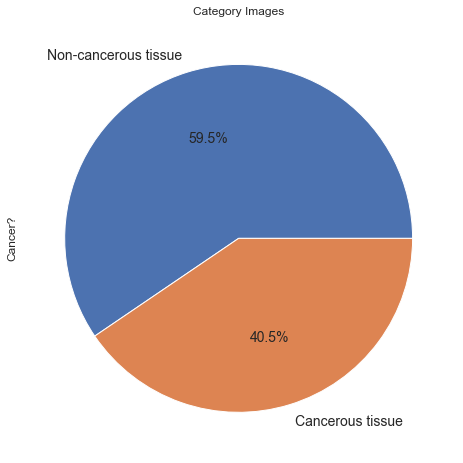

In [302]:
sns.set(style='whitegrid')

pie_chart = pd.DataFrame(full_data_pd['is_cancer'].replace(False,'Non-cancerous tissue').replace(True,'Cancerous tissue').value_counts())

pie_chart.reset_index(inplace=True)

pie_chart.plot(kind = 'pie', 
               title = 'Category Images',
               y = 'is_cancer', 
               autopct = '%1.1f%%', 
               shadow = False, 
               labels = pie_chart['index'], 
               legend = False, 
               ylabel = 'Cancer?',
               fontsize = 14, 
               figsize = (18,8))


As we see our data is unbalanced. Unbalanced data set can lead to the problem is that models trained on unbalanced datasets often have poor results when they have to generalize (predict a class or classify unseen observations). So to avoid this problem we are going to undersample the data to the lowest number which corresponds to 89117 avoiding sidetracked predictions in our future model (As a side effect this is going to make running our model on our laptops easier since originally it took us a lot of time).

Again lets take a look at the given shape of a single image

In [304]:
full_data_pd['image'].iloc[0].shape

(96, 96, 3)

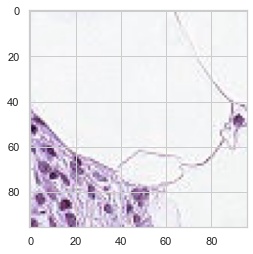

In [306]:
plt.imshow(full_data_pd['image'].iloc[0])

From the shape we can see that our images are 96x96 with three color channels. Lets visualy some images and their labels. Since a positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue we'll circle the 32x32 center with a patch. A blue color for negative and a red color for positive.

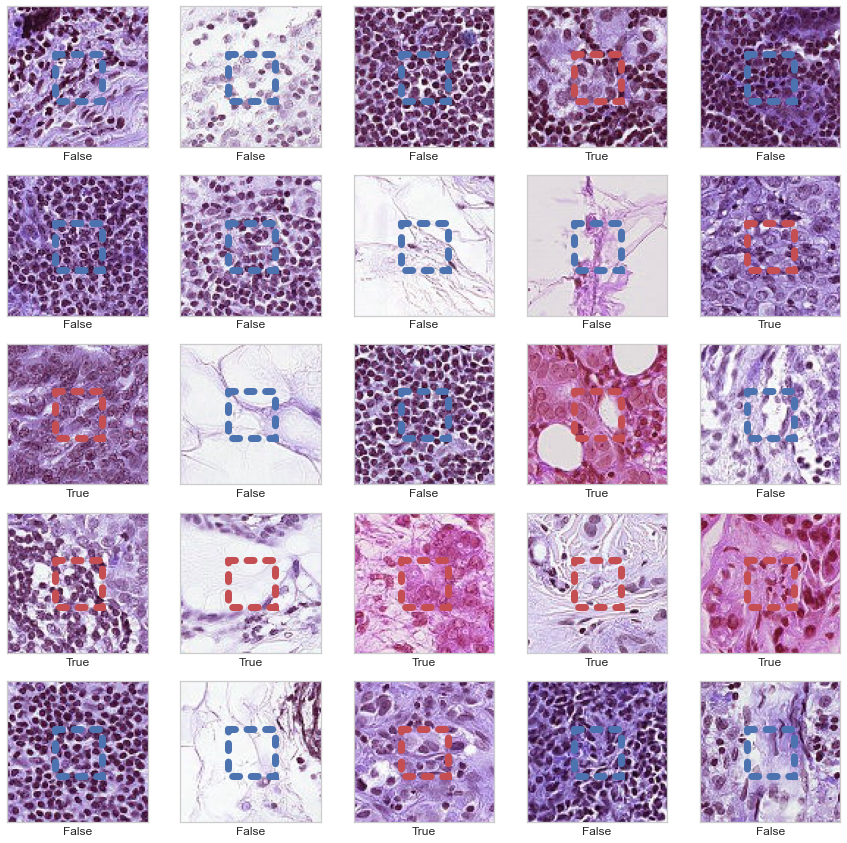

In [312]:
fig, ax = plt.subplots(5, 5, figsize=(15,15))

shuffled_data = shuffle(full_data_pd)

for (i,current_subplot) in zip(range(25),ax.flat):
    current_row = shuffled_data.iloc[i]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    try:
        # read image and add to plot
        current_subplot.imshow(current_row['image'])
        
        current_label = current_row['is_cancer']
        
        if (current_label == True):
            current_patch_color = 'r'
        else:
            current_patch_color = 'b'
        
        # create patch recatangle around the suspected area
        box = patches.Rectangle((32,32),32,32, linewidth=7, edgecolor=current_patch_color, facecolor='none', linestyle=':', capstyle='round')
        
        # add labels and patch 
        current_subplot.xaxis.label.set_text(current_row['is_cancer'])
        current_subplot.add_patch(box)
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()


Using the naked eye, being untrained professionals, we can't make a difference between the cancerous and none cancerous images. Lets explore some more charasteristics of these images to try and spot differences that we can take into consideration when building our model.

### Exploring image pixel values distribution

Reshaping our image array in such a way it'll be easier to visualize. 

In [18]:
stacked_negative_images = np.stack(full_data_pd[full_data_pd['is_cancer'] == False]['image'], axis=0)
stacked_positive_images = np.stack(full_data_pd[full_data_pd['is_cancer'] == True]['image'], axis=0)

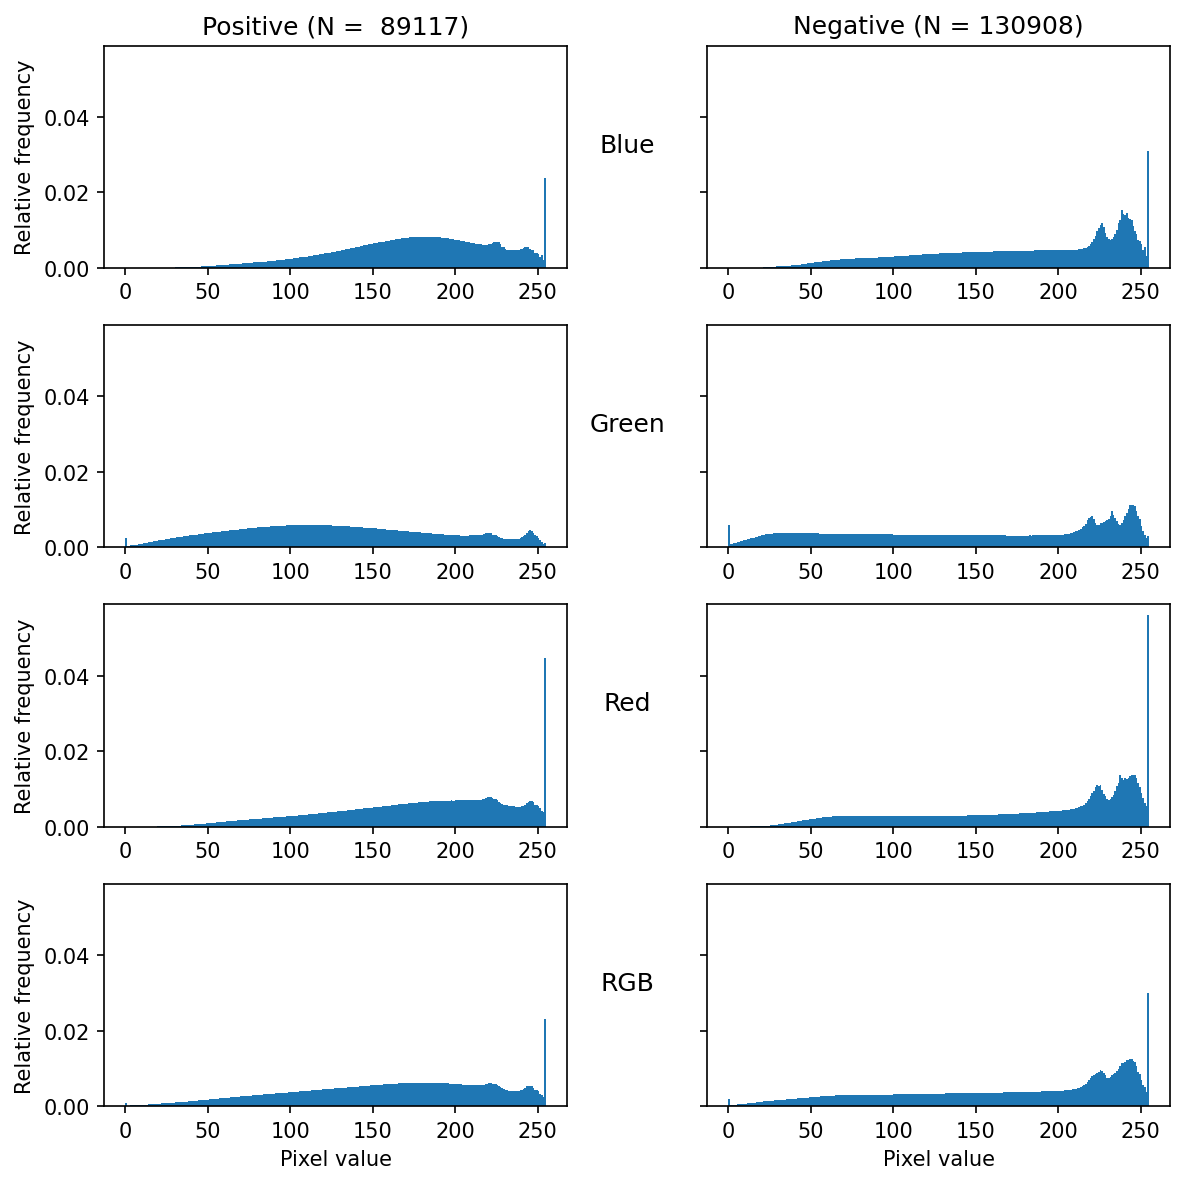

In [19]:
fig, axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

#RGB channels

# BLUE channel
axs[0,0].hist(stacked_positive_images[:,:,:,0].flatten(),bins=256,density=True)
axs[0,1].hist(stacked_negative_images[:,:,:,0].flatten(),bins=256,density=True)

# GREEN channel
axs[1,0].hist(stacked_positive_images[:,:,:,1].flatten(),bins=256,density=True)
axs[1,1].hist(stacked_negative_images[:,:,:,1].flatten(),bins=256,density=True)

# RED Channel
axs[2,0].hist(stacked_positive_images[:,:,:,2].flatten(),bins=256,density=True)
axs[2,1].hist(stacked_negative_images[:,:,:,2].flatten(),bins=256,density=True)

#All channels
axs[3,0].hist(stacked_positive_images.flatten(),bins=256,density=True)
axs[3,1].hist(stacked_negative_images.flatten(),bins=256,density=True)

#Set image labels
axs[0,0].set_title("Positive (N =  " + str(stacked_positive_images.shape[0]) + ")");
axs[0,1].set_title("Negative (N = " + str(stacked_negative_images.shape[0]) + ")");

axs[0,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)

for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
    
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")

fig.tight_layout()

plt.show()

Looking at these plots we can notice several interesting differences between cancerous and non cancerous samples.

* In general looks like there is a peak of very bright images (250 pixel value frequenncy, white). We cann see the frequency peak for blue and red channels, for both cancerous and non cancerous images, and also for all colors all together (RGB).
* There are no such peak only for the green channel in both cancerous and non cancerous images.
* Non cancerous images seem to be brighter, higher values more frequent, than cancerous images.
* Cancerous images tend to have lower frequency values for the green channel, meaning the green color in the is darker, compared to the reds and blues which are brighter and more dominant. This is very interesting since when a pathologist looks at a biopsy of a suspected cancer, the histological section is likely to be stained with a combination of hematoxylin and eosin, it produces blues, violets and reds (Fox, 2000; Krithiga & Geetha, 2020).
* Non cancerous images have lighter pixel frequency for all color channels.

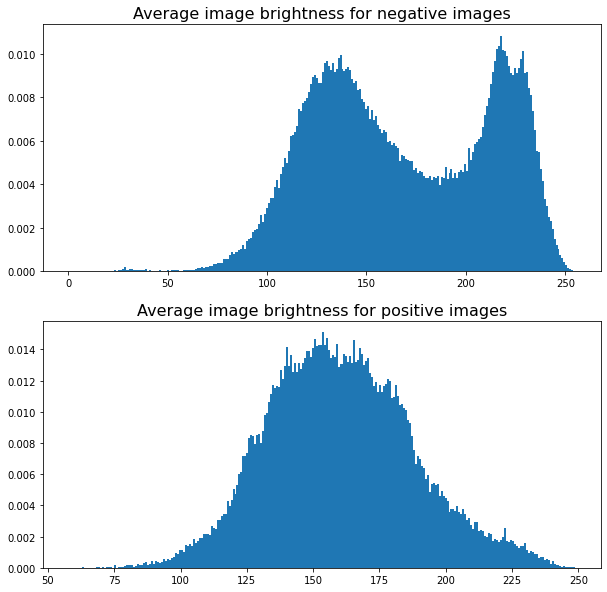

In [20]:
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].hist(np.mean(stacked_negative_images, axis=(1,2,3)), bins=256, density=True)
ax[1].hist(np.mean(stacked_positive_images, axis=(1,2,3)), bins=256, density=True)

ax[0].set_title("Average image brightness for negative images", fontsize=16)
ax[1].set_title("Average image brightness for positive images", fontsize=16)

plt.show()

Interestingly enough we can see that there is a difference in image brightness between cancerous and non cancerous images.
* Cancerous images have a normal like distribution of image brightness.
* Non cancerous images have a multimodal distribution of image brightness. 

### Exploring low/high contract images

In [326]:
from skimage.exposure import is_low_contrast

In [327]:
def is_low_contrast_func(image):
    return bool(is_low_contrast(image, fraction_threshold=0.1))

In [329]:
low_contrast_pd = full_data_pd.copy()
low_contrast_pd['is_low_contrast_0.1'] = low_contrast_pd['image'].apply(is_low_contrast_func)

<AxesSubplot:xlabel='is_low_contrast_0.1', ylabel='count'>

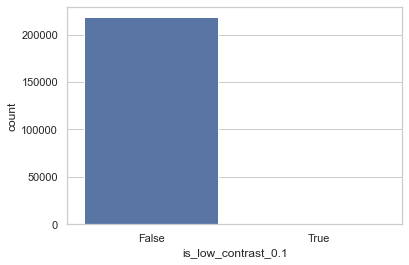

In [334]:
sns.countplot(data=low_contrast_pd, x='is_low_contrast_0.1')

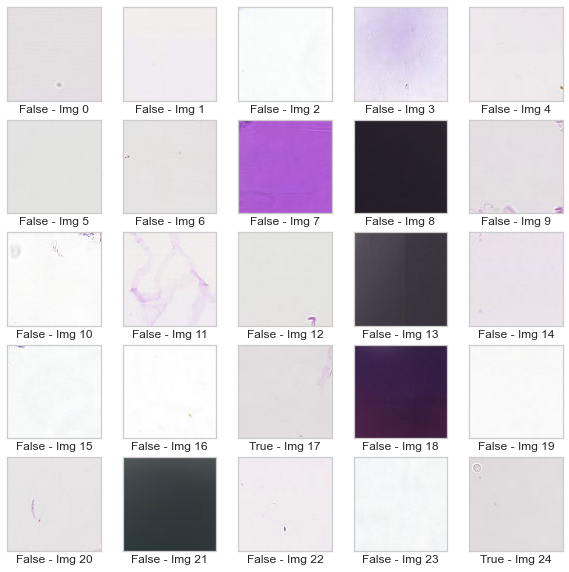

In [343]:
plt.figure(figsize=(10,10))

shuffled_low_contrast = shuffle(low_contrast_pd[low_contrast_pd["is_low_contrast_0.1"] == True])

for i in range(25):
    current_row = shuffled_low_contrast.iloc[i]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    try:
        plt.imshow(current_row['image'])

        plt.xlabel(f"{current_row['is_cancer']} - Img {i}")
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()

These immages look generally like mistakes even to the naked eye. Some look like mmaybe the edge of the microscope scanning the sample being too dark or too bright. Some look completly single color. In other words these look like images that don't have an actual sample of tissue in them. 

At this point we want to drill down into the labels these low contrast images belong to, to gain some more insights.

<AxesSubplot:xlabel='is_cancer', ylabel='count'>

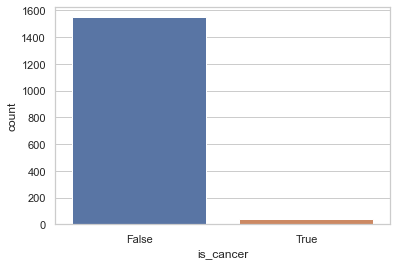

In [349]:
sns.countplot(data=low_contrast_pd[low_contrast_pd["is_low_contrast_0.1"] == True], x='is_cancer')

Looks like most images belong to non cancerous tissue images. This is interesting, because from what we see when visualising a sample of images and from what we gather, thesea are indeed non cancerous images. Lets take a look at some of these images.

/Users/simonameriam/.conda/envs/data_sciense_keras_project/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


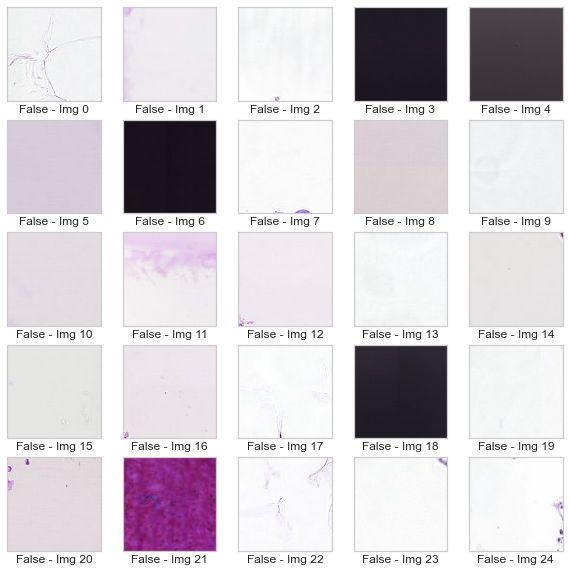

In [348]:
plt.figure(figsize=(10,10))

shuffled_low_contrast = shuffle(low_contrast_pd[low_contrast_pd["is_low_contrast_0.1"] == True][low_contrast_pd['is_cancer'] == False])

for i in range(25):
    current_row = shuffled_low_contrast.iloc[i]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    try:
        plt.imshow(current_row['image'])

        plt.xlabel(f"{current_row['is_cancer']} - Img {i}")
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()

Surprisingly enough although some of these images are indeed single color

/Users/simonameriam/.conda/envs/data_sciense_keras_project/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


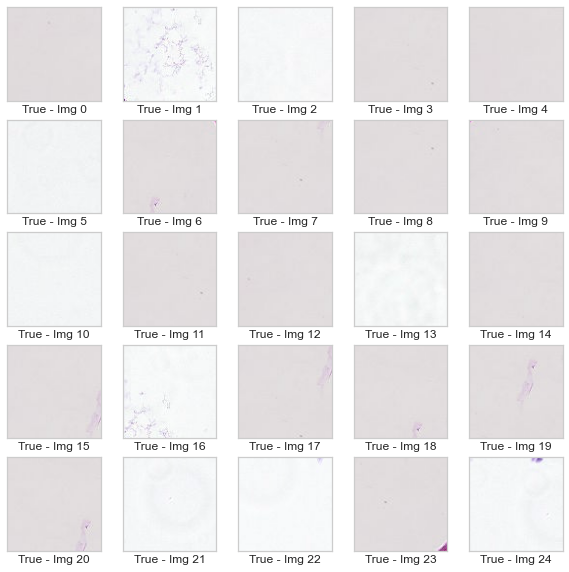

In [347]:
fig, ax = plt.figure(figsize=(10,10))

shuffled_low_contrast = shuffle(low_contrast_pd[low_contrast_pd["is_low_contrast_0.1"] == True][low_contrast_pd['is_cancer'] == True])

for i in range(25):
    current_row = shuffled_low_contrast.iloc[i]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    try:
        plt.imshow(current_row['image'])

        plt.xlabel(f"{current_row['is_cancer']} - Img {i}")
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()

In [40]:
def is_low_contrast_func_01(file_name):
    return bool(is_low_contrast(plt.imread(file_name), fraction_threshold=0.05))

In [41]:
isLowContrastUDF = udf(lambda file_name: is_low_contrast_func_01(file_name),BooleanType())

In [42]:
y_low_contrast_df = y_trs_df.withColumn('is_low_contrast', isLowContrastUDF('file_name'))

In [43]:
y_low_contrast_df.persist()

DataFrame[id: string, label: string, translated_label: boolean, file_name: string, is_low_contrast: boolean]

In [44]:
y_low_contrast_df.show()

+--------------------+-----+----------------+--------------------+---------------+
|                  id|label|translated_label|           file_name|is_low_contrast|
+--------------------+-----+----------------+--------------------+---------------+
|00001b2b5609af42a...|    1|            true|../../data/histop...|          false|
|000020de2aa6193f4...|    0|           false|../../data/histop...|          false|
|00004aab08381d25d...|    0|           false|../../data/histop...|          false|
|0000d563d5cfafc4e...|    0|           false|../../data/histop...|          false|
|0000da768d06b879e...|    1|            true|../../data/histop...|          false|
|0000f8a4da4c286ee...|    0|           false|../../data/histop...|          false|
|00010f78ea8f87811...|    0|           false|../../data/histop...|          false|
|00011545a49581781...|    0|           false|../../data/histop...|          false|
|000126ec42770c756...|    0|           false|../../data/histop...|          false|
|000

In [45]:
y_to_plot = y_low_contrast_df.toPandas()

<AxesSubplot:xlabel='is_low_contrast', ylabel='count'>

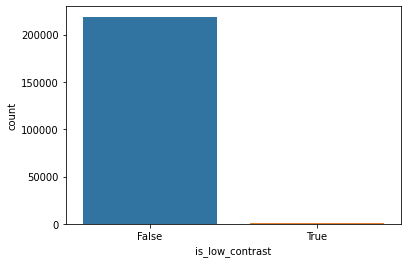

In [84]:
sns.countplot(data=y_to_plot, x='is_low_contrast')

In [46]:
y_to_plot.groupby(['is_low_contrast']).count()

,id,label,translated_label,file_name
is_low_contrast,,,,
False,218888,218888,218888,218888
True,1137,1137,1137,1137


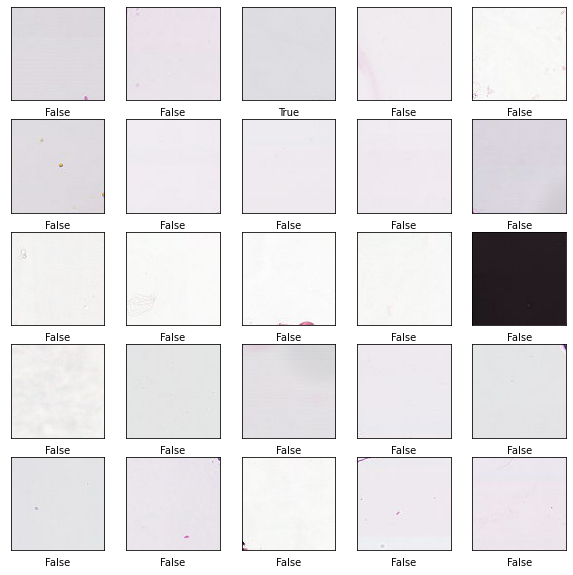

In [86]:
plt.figure(figsize=(10,10))

shuffled_low_contrast = shuffle(y_to_plot[y_to_plot["is_low_contrast"] == True])

for i in range(25):
    current_row = shuffled_low_contrast.iloc[[i]]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # get file name from cell
    curr_file_path = current_row['file_name'].iloc[0]
    
    try:
        img = plt.imread(curr_file_path)
        plt.imshow(img)

        plt.xlabel(current_row['translated_label'].iloc[0])
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()

In [47]:
y_to_plot[y_to_plot["is_low_contrast"] == True].groupby(['translated_label']).count()

,id,label,file_name,is_low_contrast
translated_label,,,,
False,1099,1099,1099,1099
True,38,38,38,38


It looks like the most very high/low exposure images are classified as False but some are classified as True. Lets take a look at each group.

/Users/simonameriam/.conda/envs/data_sciense_keras_project/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


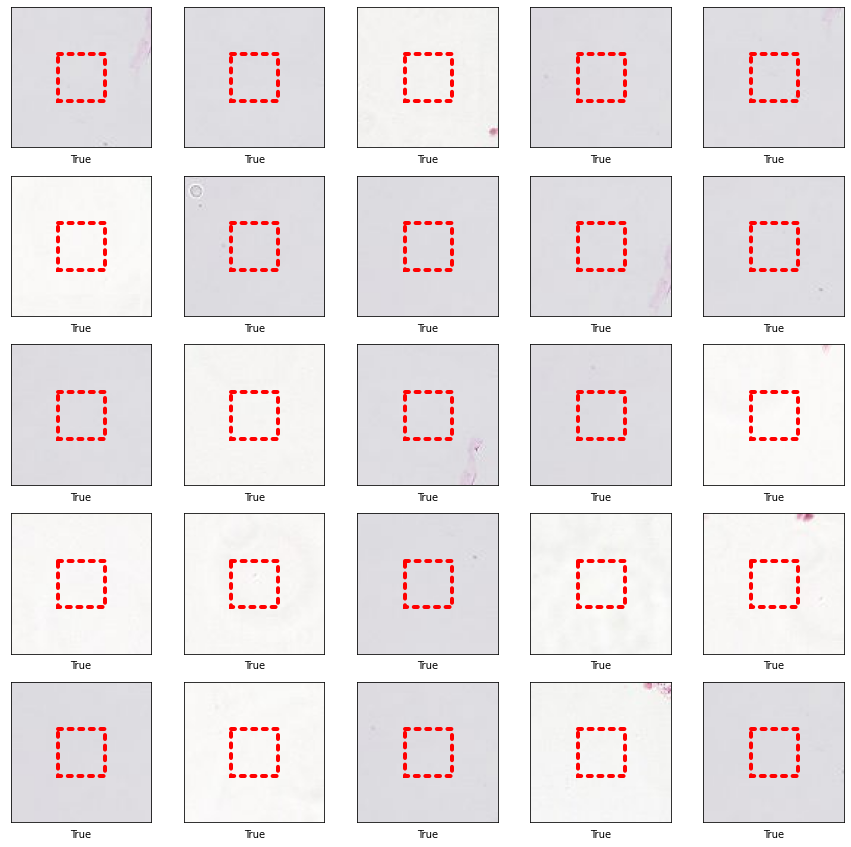

In [135]:
fig, ax = plt.subplots(5,5,figsize=(15,15))

shuffled_low_contrast = shuffle(y_to_plot[y_to_plot["is_low_contrast"] == True][ y_to_plot["translated_label"] == True])

for (i,current_subplot) in zip(range(25),ax.flat):
    current_row = shuffled_low_contrast.iloc[[i]]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # get file name from cell
    curr_file_path = current_row['file_name'].iloc[0]
    
    try:
        # read image and add to plot
        img = plt.imread(curr_file_path)
        current_subplot.imshow(img)
        
        current_label = current_row['translated_label'].iloc[0]
        
        if (current_label == True):
            current_patch_color = 'r'
        else:
            current_patch_color = 'b'
        
        # create patch recatangle around the suspected area
        box = patches.Rectangle((32,32),32,32, linewidth=4, edgecolor=current_patch_color, facecolor='none', linestyle=':', capstyle='round')
        
        # add labels and patch 
        current_subplot.xaxis.label.set_text(current_row['translated_label'].iloc[0])
        current_subplot.add_patch(box)
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()

/Users/simonameriam/.conda/envs/data_sciense_keras_project/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


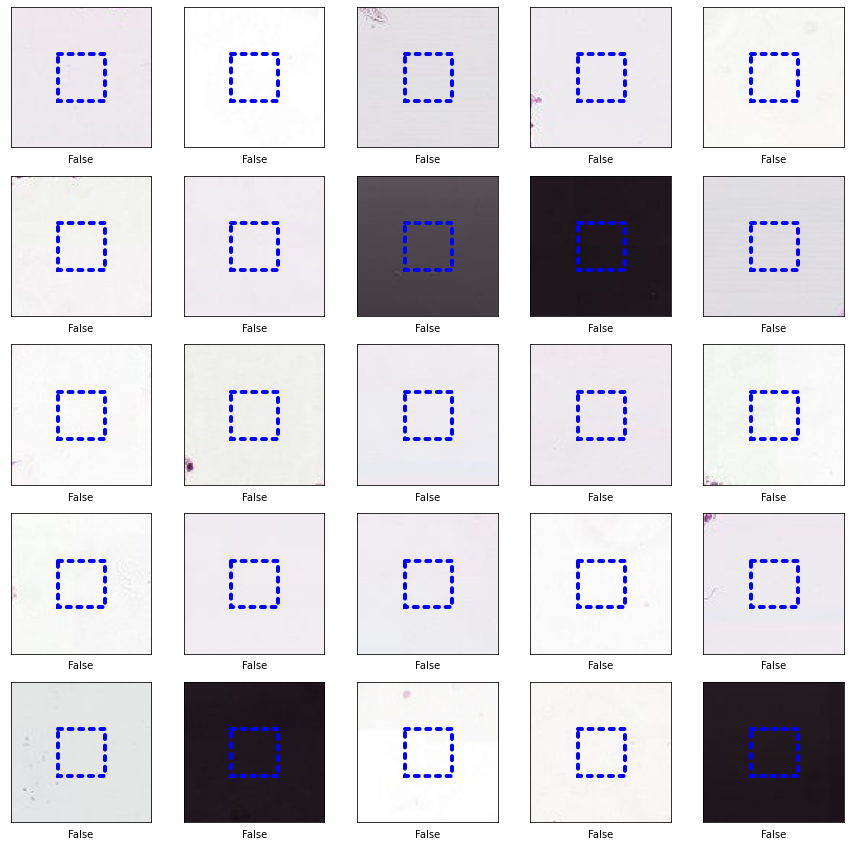

In [136]:
fig, ax = plt.subplots(5,5,figsize=(15,15))

shuffled_low_contrast = shuffle(y_to_plot[y_to_plot["is_low_contrast"] == True][ y_to_plot["translated_label"] == False])

for (i,current_subplot) in zip(range(25),ax.flat):
    current_row = shuffled_low_contrast.iloc[[i]]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # get file name from cell
    curr_file_path = current_row['file_name'].iloc[0]
    
    try:
        # read image and add to plot
        img = plt.imread(curr_file_path)
        current_subplot.imshow(img)
        
        current_label = current_row['translated_label'].iloc[0]
        
        if (current_label == True):
            current_patch_color = 'r'
        else:
            current_patch_color = 'b'
        
        # create patch recatangle around the suspected area
        box = patches.Rectangle((32,32),32,32, linewidth=4, edgecolor=current_patch_color, facecolor='none', linestyle=':', capstyle='round')
        
        # add labels and patch 
        current_subplot.xaxis.label.set_text(current_row['translated_label'].iloc[0])
        current_subplot.add_patch(box)
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()

In general it looks like most of these images are very dark/very bright and there is nothing to the naked eye in the 32x32 diameter of the triangle. Not all images are single tone so let's get the threshold a little bit higher.

In [48]:
def is_low_contrast_func(file_name):
    return bool(is_low_contrast(plt.imread(file_name), fraction_threshold=0.005))

isLowContrastUDF = udf(lambda file_name: is_low_contrast_func(file_name),BooleanType())

y_low_contrast_df = y_trs_df.withColumn('is_low_contrast', isLowContrastUDF('file_name'))

y_low_contrast_df.persist()

y_low_contrast_df.show()

+--------------------+-----+----------------+--------------------+---------------+
|                  id|label|translated_label|           file_name|is_low_contrast|
+--------------------+-----+----------------+--------------------+---------------+
|00001b2b5609af42a...|    1|            true|../../data/histop...|          false|
|000020de2aa6193f4...|    0|           false|../../data/histop...|          false|
|00004aab08381d25d...|    0|           false|../../data/histop...|          false|
|0000d563d5cfafc4e...|    0|           false|../../data/histop...|          false|
|0000da768d06b879e...|    1|            true|../../data/histop...|          false|
|0000f8a4da4c286ee...|    0|           false|../../data/histop...|          false|
|00010f78ea8f87811...|    0|           false|../../data/histop...|          false|
|00011545a49581781...|    0|           false|../../data/histop...|          false|
|000126ec42770c756...|    0|           false|../../data/histop...|          false|
|000

In [49]:
y_to_plot = y_low_contrast_df.toPandas()

<AxesSubplot:xlabel='is_low_contrast', ylabel='count'>

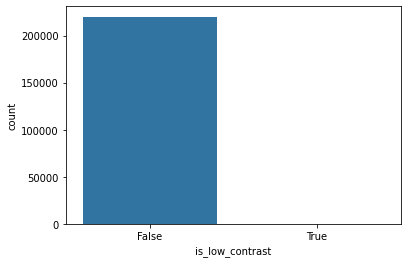

In [148]:
sns.countplot(data=y_to_plot, x='is_low_contrast')

In [149]:
y_to_plot[y_to_plot["is_low_contrast"] == True].groupby(['translated_label']).count()

,id,label,file_name,is_low_contrast
translated_label,,,,
False,17,17,17,17


So for the top threshold of 0.005 images we are left with 17 images all classified as False. Lets look at them

/Users/simonameriam/.conda/envs/data_sciense_keras_project/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


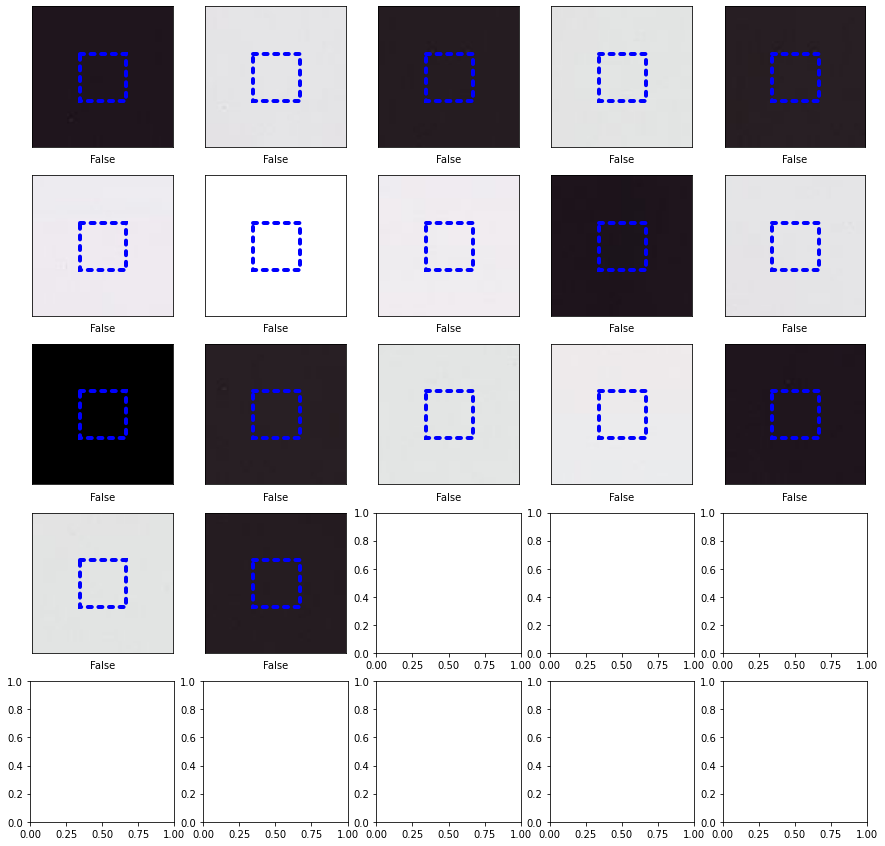

In [155]:
fig, ax = plt.subplots(5,5,figsize=(15,15))

shuffled_low_contrast = y_to_plot[y_to_plot["is_low_contrast"] == True][ y_to_plot["translated_label"] == False]

for (i,current_subplot) in zip(range(17),ax.flat):
    current_row = shuffled_low_contrast.iloc[[i]]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # get file name from cell
    curr_file_path = current_row['file_name'].iloc[0]
    
    try:
        # read image and add to plot
        img = plt.imread(curr_file_path)
        current_subplot.imshow(img)
        
        current_label = current_row['translated_label'].iloc[0]
        
        if (current_label == True):
            current_patch_color = 'r'
        else:
            current_patch_color = 'b'
        
        # create patch recatangle around the suspected area
        box = patches.Rectangle((32,32),32,32, linewidth=4, edgecolor=current_patch_color, facecolor='none', linestyle=':', capstyle='round')
        
        # add labels and patch 
        current_subplot.xaxis.label.set_text(current_row['translated_label'].iloc[0])
        current_subplot.add_patch(box)
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()

It looks like all of these images are indeed very dark or very bright and don't represent actual cells or biopsies, we believe we can remove these.

In [50]:
cleaned_y_df = y_low_contrast_df.filter(col("is_low_contrast") == False)

In [38]:
cleaned_y_df.show()

+--------------------+-----+----------------+--------------------+---------------+
|                  id|label|translated_label|           file_name|is_low_contrast|
+--------------------+-----+----------------+--------------------+---------------+
|00001b2b5609af42a...|    1|            true|../../data/histop...|          false|
|000020de2aa6193f4...|    0|           false|../../data/histop...|          false|
|00004aab08381d25d...|    0|           false|../../data/histop...|          false|
|0000d563d5cfafc4e...|    0|           false|../../data/histop...|          false|
|0000da768d06b879e...|    1|            true|../../data/histop...|          false|
|0000f8a4da4c286ee...|    0|           false|../../data/histop...|          false|
|00010f78ea8f87811...|    0|           false|../../data/histop...|          false|
|00011545a49581781...|    0|           false|../../data/histop...|          false|
|000126ec42770c756...|    0|           false|../../data/histop...|          false|
|000

In [39]:
cleaned_y_df.groupBy("is_low_contrast").count().show()

+---------------+------+
|is_low_contrast| count|
+---------------+------+
|          false|220008|
+---------------+------+



In [51]:
y_to_plot = cleaned_y_df.toPandas()

<AxesSubplot:xlabel='translated_label', ylabel='count'>

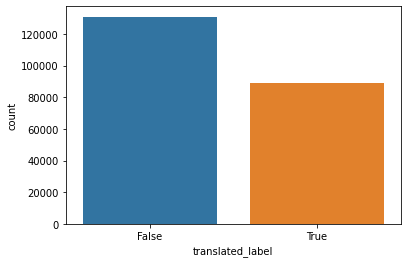

In [41]:
sns.countplot(data=y_to_plot, x='translated_label')

## Load image train set

Before the splitting out data, let's balance it. Althought the data is not very unbalanced, we decided to do this since the amount of images was taking us a lot of time to tain. We have to create dataframes containing the id's of each category and gather 89000 images as we said earlier randomly:

In [60]:
SAMPLE_SIZE=89000

# take a random sample of class 0 with size equal to num samples in class 1
df_0 = y_sorted[ y_sorted['translated_label'] == True ].sample(SAMPLE_SIZE, random_state = 42)

# filter out class 1
df_1 = y_sorted[ y_sorted['translated_label'] == False ].sample(SAMPLE_SIZE, random_state = 42)

Once we created both dataframes we will concatenate them so as to have one file containing 178000 images, finally we will shuffle it because it was sorted:

In [61]:
from sklearn.utils import shuffle

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['translated_label'].value_counts()

False    89000
True     89000
Name: translated_label, dtype: int64

In [79]:
#df_data.drop('file_name',inplace=True, axis=1)
df_data.drop('translated_label',inplace=True, axis=1)

In [80]:
df_data.head(10)

,id,label
122652,1c3f1795685060598187570a1b17440902387285,0
73857,4884e9a48b68d6ab4a76440d2982c2f59bbdc86d,1
160984,8aadbf6bb6666a650f9cc9637618286a5415a7f5,0
156606,a6b8a17590d24338e5c1b308ebbe8bd46528eb46,0
138396,7d6ec81d4cf93407f76378926c1737df8214cfce,0
48731,41610b29a15929952ed65963029ae91f1c2a8bd4,1
107916,94db7a4faf6fefe1599d03c6c0048ca284ea824b,0
20743,478fb3d24d6ac3941798e30461bd581d1733bc57,1
62181,1e130e0c0958e93e276945531e77f9d62669133e,1
84736,64cdf8e28590a1110b19cc52de542c81a59fa3f3,1


In [87]:
df_data.keys

<bound method NDFrame.keys of                                               id label
122652  1c3f1795685060598187570a1b17440902387285     0
73857   4884e9a48b68d6ab4a76440d2982c2f59bbdc86d     1
160984  8aadbf6bb6666a650f9cc9637618286a5415a7f5     0
156606  a6b8a17590d24338e5c1b308ebbe8bd46528eb46     0
138396  7d6ec81d4cf93407f76378926c1737df8214cfce     0
...                                          ...   ...
118570  f2dd6373ddf242f6eb4792c41b0a541de8e3ac20     0
173173  b6e7aee2aeebc2be737699d37c226784e0806080     0
88497   719281706546465562db647f47ced381e4882833     1
6826    d85b17275d81b1bb9dfddc5b49af0940e82bca39     1
158631  481ca511c0d15df6ac0d4b0c916c8f9e089fbafe     0

[178000 rows x 2 columns]>

Now that we have a balanced dataset we can split into training and validation sets at 10% as a typical ML workflow.

In [81]:
# train_test_split
from sklearn.model_selection import train_test_split

# stratify=y creates a balanced validation set.
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=42, stratify=y)

print(df_train.shape)
print(df_val.shape)

(160200, 2)
(17800, 2)


At this moment we could create the model and the objects containing the training and validation images according to the id's in both sets, however this process will crash our machine RAM forcing us to restart it, this is why we have to create directories and sub-directories and save the images in their respective folder, this process will consume a significative lower RAM allowing us to succesfully train our model for various epochs.

In [110]:
# Create a new directory
base_dir = 'splitted_data'
os.mkdir(base_dir)

#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create separate folders for each class

# create new folders inside train_dir
non_cancerous_tissue = os.path.join(train_dir, 'non_cancerous_tissue')
os.mkdir(non_cancerous_tissue)
cancerous_tissue = os.path.join(train_dir, 'cancerous_tissue')
os.mkdir(cancerous_tissue)

# create new folders inside val_dir
non_cancerous_tissue = os.path.join(val_dir, 'non_cancerous_tissue')
os.mkdir(non_cancerous_tissue)
cancerous_tissue = os.path.join(val_dir, 'cancerous_tissue')
os.mkdir(cancerous_tissue)


In [89]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

In [92]:
df_data.head

<bound method NDFrame.head of                                          label
id                                            
1c3f1795685060598187570a1b17440902387285     0
4884e9a48b68d6ab4a76440d2982c2f59bbdc86d     1
8aadbf6bb6666a650f9cc9637618286a5415a7f5     0
a6b8a17590d24338e5c1b308ebbe8bd46528eb46     0
7d6ec81d4cf93407f76378926c1737df8214cfce     0
...                                        ...
f2dd6373ddf242f6eb4792c41b0a541de8e3ac20     0
b6e7aee2aeebc2be737699d37c226784e0806080     0
719281706546465562db647f47ced381e4882833     1
d85b17275d81b1bb9dfddc5b49af0940e82bca39     1
481ca511c0d15df6ac0d4b0c916c8f9e089fbafe     0

[178000 rows x 1 columns]>

22/06/22 21:00:59 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 140275 ms exceeds timeout 120000 ms
22/06/22 21:00:59 WARN SparkContext: Killing executors is not supported by current scheduler.


In [111]:
import shutil

# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])



# Transfer the train images
for image in train_list:
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    # these must match the folder names
    if target == '0':
        label = 'non_cancerous_tissue'
    if target == '1':
        label = 'cancerous_tissue'

    # source path to image
    src = os.path.join('../../data/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

    

# Transfer the val images
for image in val_list:
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == '0':
        label = 'non_cancerous_tissue'
    if target == '1':
        label = 'cancerous_tissue'
    
    # source path to image
    src = os.path.join('../../data/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

#### Prepare dataframe for image gen loading

In [52]:
y_final_df = cleaned_y_df

In [53]:
model_df = y_final_df.withColumn('string_label',y_final_df['translated_label'].cast(StringType())).toPandas()

The data format we're dealing with here if tif. For this reason we can't use the image_dataset_from_directory provided by Keras. Instead we're going to use the ImageDataGenerator with

In [117]:
from keras.preprocessing.image import ImageDataGenerator

#### The image data generator is going to rescale the images, deviding them by 255 so that pixel value ranges between 0 and 1

In [118]:
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.2,
                             width_shift_range=4,  # randomly shift images horizontally
                             height_shift_range=4,  # randomly shift images vertically 
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=True)  # randomly flip image

In [176]:
batch_size=32

In [114]:
train_path = 'splitted_data/train_dir'
valid_path = 'splitted_data/val_dir'

IMAGE_SIZE = 96

In [177]:
train_set = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=batch_size,
                                        class_mode='binary',
                                        shuffle=True)

val_set = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=batch_size,
                                        class_mode='binary',
                                        shuffle=True)




val2_set = datagen.flow_from_directory(valid_path,
                                       target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                       batch_size=1,
                                       class_mode='binary',
                                       shuffle=False)

Found 160200 images belonging to 2 classes.
Found 17800 images belonging to 2 classes.
Found 17800 images belonging to 2 classes.


### Determining the size of the batch
So at this point we've actually got a pretty ugly exception if we'd set the batch size to be any number aside from 1. But then also not setting "steps_per_epoch" would put us in a bad position. 

Calculating the following metrics proves to be the same as len(train_set). So using this setting the "steps_per_epoch" is running a single image per set per the entire dataset. 

We then discovered that this exception was actually encountered because we didn't set the target_size=(96,96) in the previous section! We assumed that not setting target size would take the original image size, which is, (96,96). That assumption was clearly wrong.

In [178]:
train_steps_per_epoch = np.ceil(train_set.n / train_set.batch_size)
val_steps_per_epoch = np.ceil(val_set.n/ val_set.batch_size)

In [179]:
train_steps_per_epoch

5007.0

In [180]:
len(train_set)

5007

## Building our model

In [181]:
model = models.Sequential()
model.add(layers.Input(shape=(96, 96, 3)))

model.add(layers.Conv2D(16, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization(axis = 3))



model.add(layers.Conv2D(32, (3, 3),activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization(axis = 3))



model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization(axis = 3))



model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [174]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 47, 47, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                      

## Compiling and fitting our model

In [182]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Notice no batch size and validation batch size are specified since our data is in the form of generator, and they already generate batches.

In [183]:
cnn_history = model.fit(train_set, epochs=10, steps_per_epoch=len(train_set),
                    validation_data=val_set,verbose=1)

Epoch 1/10
5007/5007 [==============================] - 875s 175ms/step - loss: 0.4087 - accuracy: 0.8265 - val_loss: 1.5007 - val_accuracy: 0.6546
Epoch 2/10
5007/5007 [==============================] - 5027s 1s/step - loss: 0.3077 - accuracy: 0.8732 - val_loss: 0.4016 - val_accuracy: 0.8267
Epoch 3/10
5007/5007 [==============================] - 1015s 203ms/step - loss: 0.2700 - accuracy: 0.8925 - val_loss: 0.6114 - val_accuracy: 0.7615
Epoch 4/10
5007/5007 [==============================] - 1071s 214ms/step - loss: 0.2509 - accuracy: 0.9008 - val_loss: 0.4086 - val_accuracy: 0.8359
Epoch 5/10
5007/5007 [==============================] - 985s 197ms/step - loss: 0.2375 - accuracy: 0.9069 - val_loss: 0.4539 - val_accuracy: 0.8017
Epoch 6/10
5007/5007 [==============================] - 966s 193ms/step - loss: 0.2258 - accuracy: 0.9126 - val_loss: 0.3290 - val_accuracy: 0.8751
Epoch 7/10
5007/5007 [==============================] - 981s 196ms/step - loss: 0.2196 - accuracy: 0.9151 - val_

Looking at the first epoch we've noticed the loss and accuracy don't really change afte raround 50-60K images

In [127]:
from tensorflow.keras.models import Sequential, save_model, load_model

In [184]:
# Save the model
filepath_cnn = './CNN_model'
save_model(model, filepath_cnn)

INFO:tensorflow:Assets written to: ./CNN_model/assets


INFO:tensorflow:Assets written to: ./CNN_model/assets


## Using DenseNet201 as model base

In [172]:
from tensorflow.keras.applications import DenseNet201

In [149]:
# We read that best practice for output dropout layer is 0.5 (0.5<x<0.8 for input layers)
dropout_factor = 0.5

In [151]:
## TODO: Check trainability of DenseNet201 since we're using image net weights here and these should be quite different for cancer
model_base = DenseNet201(input_shape=(96, 96, 3), include_top=False)
dense_net = models.Sequential()
dense_net.add(model_base)

dense_net.add(layers.Flatten())

dense_net.add(layers.Dense(64, activation='relu'))
dense_net.add(layers.Dropout(0.2))
dense_net.add(layers.Dense(1, activation='sigmoid'))

In [152]:
dense_net.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 3, 3, 1920)        18321984  
                                                                 
 flatten_2 (Flatten)         (None, 17280)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                1105984   
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 19,428,033
Trainable params: 19,198,977
Non-trainable params: 229,056
_________________________________________________________________


In [153]:
dense_net.compile(optimizer=Adam(0.01),
              loss='binary_crossentropy',
              metrics=['accuracy','AUC'])

In [154]:
early_stopper = EarlyStopping(monitor='val_loss', patience=2, verbose=2, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [155]:
dense_history = model.fit(train_set, 
                    epochs=10, 
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=val_set, 
                    validation_steps=val_steps_per_epoch, 
                    callbacks=[early_stopper, reduce],
                    verbose=1)

Epoch 1/10
2504/2504 [==============================] - 905s 361ms/step - loss: 0.2444 - accuracy: 0.9076 - val_loss: 0.6229 - val_accuracy: 0.8139 - lr: 0.0010
Epoch 2/10
2504/2504 [==============================] - ETA: 0s - loss: 0.2367 - accuracy: 0.9112
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2504/2504 [==============================] - 966s 386ms/step - loss: 0.2367 - accuracy: 0.9112 - val_loss: 0.8886 - val_accuracy: 0.7918 - lr: 0.0010
Epoch 3/10
2504/2504 [==============================] - 920s 367ms/step - loss: 0.2151 - accuracy: 0.9208 - val_loss: 0.1739 - val_accuracy: 0.9314 - lr: 1.0000e-04
Epoch 4/10
2504/2504 [==============================] - 967s 386ms/step - loss: 0.2111 - accuracy: 0.9234 - val_loss: 0.1696 - val_accuracy: 0.9350 - lr: 1.0000e-04
Epoch 5/10
2504/2504 [==============================] - 1070s 427ms/step - loss: 0.2106 - accuracy: 0.9235 - val_loss: 0.1669 - val_accuracy: 0.9356 - lr: 1.0000e-04
Epoch 6/10
2504/25

In [156]:
# Save the model
filepath_dense = './Dense_model'
save_model(dense_net, filepath_dense)

INFO:tensorflow:Assets written to: ./Dense_model/assets


INFO:tensorflow:Assets written to: ./Dense_model/assets


In [157]:
def metrics_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1,len(acc)+1,1)

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Comparing the accuracy of two models

In [185]:
pd.DataFrame(cnn_history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.408654,0.826492,1.500675,0.654551
1,0.307730,0.873215,0.401563,0.826685
2,0.270044,0.892466,0.611382,0.761517
3,0.250899,0.900768,0.408614,0.835899
4,0.237514,0.906929,0.453924,0.801742
5,0.225813,0.912628,0.329013,0.875056
6,0.219594,0.915125,0.354196,0.873146
7,0.212308,0.918858,0.199580,0.922303
8,0.208533,0.920499,0.250245,0.902360
9,0.202283,0.923152,0.269790,0.899494


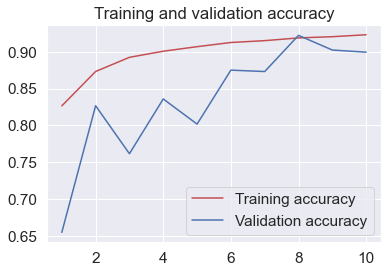

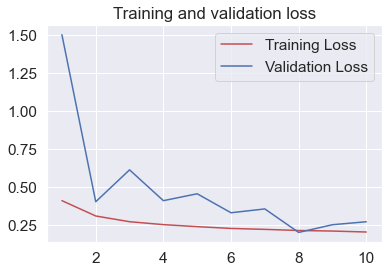

In [186]:
metrics_plot(cnn_history)

In [160]:
pd.DataFrame(dense_history.history)

,loss,accuracy,val_loss,val_accuracy,lr
0,0.244418,0.907603,0.622871,0.813876,0.00100
1,0.236691,0.911223,0.888626,0.791798,0.00100
2,0.215138,0.920818,0.173853,0.931404,0.00010
3,0.211091,0.923408,0.169616,0.935000,0.00010
4,0.210582,0.923496,0.166915,0.935562,0.00010
5,0.206982,0.924800,0.196712,0.918708,0.00010
6,0.205494,0.924657,0.163769,0.935787,0.00001
7,0.206217,0.924650,0.162790,0.936573,0.00001
8,0.204642,0.925556,0.160880,0.936404,0.00001
9,0.204872,0.925175,0.160310,0.939494,0.00001


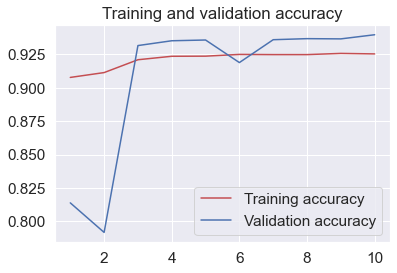

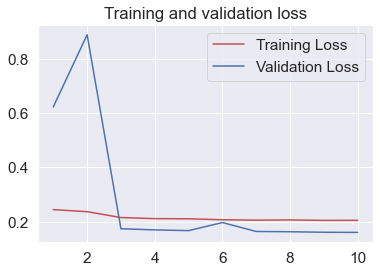

In [161]:
metrics_plot(dense_history)

Let's compare the accuracy of CNN model and DenseNet model.


At the moment our CNN model has an accuracy of ~85% on the training set and ~80% on the validation set. This means that we can expect our model to perform with ~80% accuracy on new data. On first two epochs our model accuracy metric increases on training set, while decreases on validation set. This means that our model is fitting the training set better, but is losing its ability to predict on new data, indicating that our model is starting to fit on noise and is beginning to overfit.But on the next epochs we see that accuracy of validation set is increasing. Still have to improve our model to get better accuracy and avoid the overfiting.

DenseNet model has an accuracy of ~89% on the training set and ~92% on validation set, it's much better than the CNN model. DenseNet model gives us higher accuracy on the validation set neither the training set. But the val_accuracy was getting higher only on two last epochs and got higher on ~15% than accuracy metric on first three epochs. On the third epoch we didn't get the accuracy of the validation set, because was no improvement since previous epoch.

In [187]:
from sklearn.metrics import confusion_matrix

In [188]:
#load the cnn and dense model
model_cnn = load_model(filepath_cnn, compile = True)
model_dense=load_model(filepath_dense,compile=True)

In [196]:
import matplotlib.pyplot as plt

In [189]:
predictions_cnn = model_cnn.predict_generator(val2_set, verbose=1)

   10/17800 [..............................] - ETA: 1:39 

/var/folders/rz/mg07kb5d5sq7nxt3pjc8x1v13yjw0y/T/ipykernel_1508/3537427310.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions_cnn = model_cnn.predict_generator(val2_set, verbose=1)


17800/17800 [==============================] - 84s 5ms/step


In [190]:
y_val_pred_cnn=np.round(predictions_cnn)

In [191]:
y_val_pred_cnn

array([[1.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [192]:
y_true = val2_set.classes

In [164]:
predictions_dense=model_dense.predict_generator(val2_set, verbose=1)

    1/17800 [..............................] - ETA: 30:29

/var/folders/rz/mg07kb5d5sq7nxt3pjc8x1v13yjw0y/T/ipykernel_1508/1453800772.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions_dense=model_dense.predict_generator(val2_set, verbose=1)


17800/17800 [==============================] - 1101s 62ms/step


In [165]:
y_val_pred_dense=np.round(predictions_dense)

In [193]:
confusion_cnn_mtx = confusion_matrix(y_true, y_val_pred_cnn)
#confusion_dense_mtx = confusion_matrix(y_true,y_val_pred_dense)

In [166]:
confusion_dense_mtx = confusion_matrix(y_true,y_val_pred_dense)

In [194]:
confusion_cnn_mtx

array([[8061,  839],
       [ 957, 7943]])

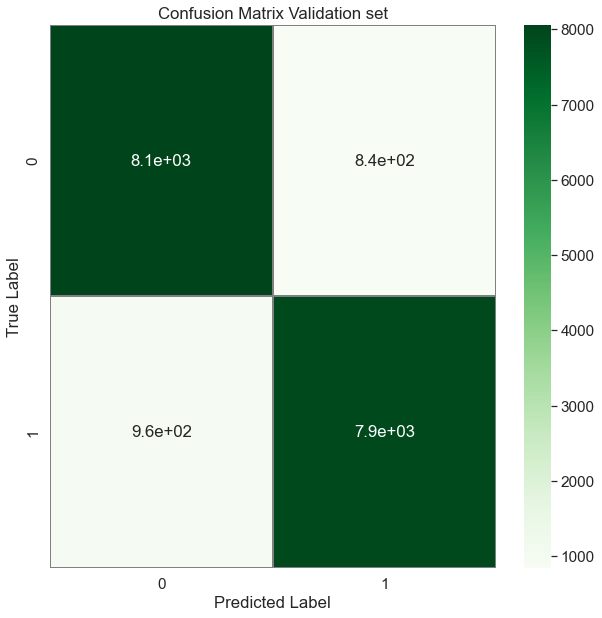

In [195]:
f,ax = plt.subplots(figsize=(10, 10))

sns.set(font_scale=1.4)
sns.heatmap(confusion_cnn_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Validation set")
plt.show()

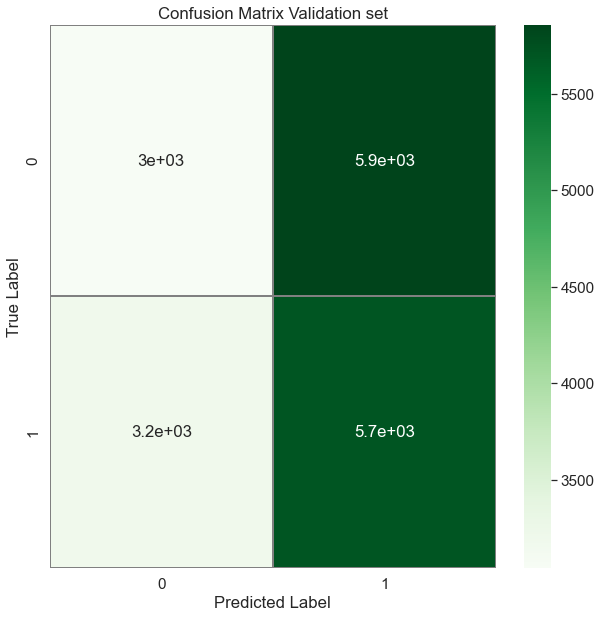

In [167]:
f,ax = plt.subplots(figsize=(10, 10))

sns.set(font_scale=1.4)
sns.heatmap(confusion_dense_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Validation set")
plt.show()

In [196]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

In [197]:
ns_probs = [0 for _ in range(len(y_true))]

In [198]:

cnn_auc = roc_auc_score(y_true, y_val_pred_cnn)
#dense_auc=roc_auc_score(y_true, y_val_pred_dense)

In [168]:
dense_auc=roc_auc_score(y_true, y_val_pred_dense)

In [199]:
print('CNN: ROC AUC=%.3f' % (cnn_auc))
print('Dense: ROC AUC=%.3f' % (dense_auc))

CNN: ROC AUC=0.899
Dense: ROC AUC=0.491


In [200]:
ns_fpr_cnn, ns_tpr_cnn, _ = roc_curve(y_true, ns_probs)
lr_fpr_cnn, lr_tpr_cnn, _ = roc_curve(y_true,predictions_cnn)

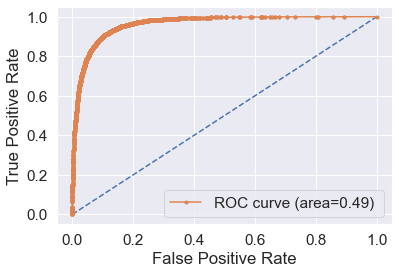

In [201]:
# plot the roc curve for the model
pyplot.plot(ns_fpr_cnn, ns_tpr_cnn, linestyle='--', label='')
pyplot.plot(lr_fpr_cnn, lr_tpr_cnn, marker='.', label='ROC curve (area=0.49) ')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [170]:
ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_true, predictions_dense)


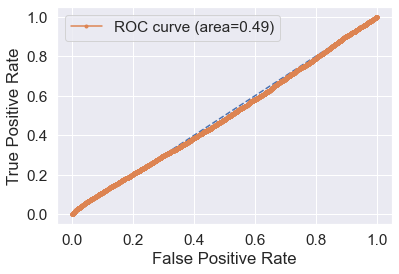

In [171]:
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ROC curve (area=0.49)')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

As we see from the graphs the value of the AUC is less then the random choice of 0.5, that's mean we should improve our model to get better accuracy on the new data. We run only 5 epochs ,so we are going to increase amount of epoch and see if it leads us to the highest accuracy on the new data.

### Plans for the next month 

1) Improve our CNN model
2) Integrate the shap tool 
3) Fix bugs that related to image pixel values distribution
4) We were trying to use k-means clustering for image classification as well but faced the problem on splitting our data to train and test sets while using the sklearn function train_test_split. The problem is the shape of the data is to big (200250,96,96,3), our machines haven't not enough cores to process this amount of data. We were thinking to use cuda, maybe you can advise us better ways to do so or just decrease this amount for clustering part? Thanks in advance.

## References
1. Fox H. (2000). Is H&E morphology coming to an end?. Journal of clinical pathology, 53(1), 38–40. https://doi.org/10.1136/jcp.53.1.38
1. Krithiga, R., Geetha, P. Breast Cancer Detection, Segmentation and Classification on Histopathology Images Analysis: A Systematic Review. Arch Computat Methods Eng 28, 2607–2619 (2021). https://doi.org/10.1007/s11831-020-09470-w
